In [1]:
import re
import json
import pandas as pd
import numpy as np
from scipy import stats
import google.cloud.bigquery as bq
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery data
SELECT
  *
FROM `curious-bot.homes.ad_details`
WHERE price_per_sq_m IS NOT NULL
  AND post_code IS NOT NULL

In [4]:
data.set_index('id', inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9050 entries, bde31f8e-ccce-4d0a-8d69-d5734cd20083 to 9820d400-bf7b-403f-b49c-3a4fb0729026
Data columns (total 16 columns):
new_building      9050 non-null bool
promoted          9050 non-null bool
price             9050 non-null int64
area              9050 non-null int64
price_per_sq_m    9050 non-null int64
type              9050 non-null object
viewed            9050 non-null datetime64[ns, UTC]
address           9050 non-null object
post_code         9050 non-null object
street_num        9037 non-null object
street_name       9046 non-null object
postal_town       9050 non-null object
country           9050 non-null object
lat               9050 non-null float64
lng               9050 non-null float64
short_desc        9050 non-null object
dtypes: bool(2), datetime64[ns, UTC](1), float64(2), int64(3), object(8)
memory usage: 1.1+ MB


In [6]:
data['log_price_per_sq_m'] = np.log1p(data.price_per_sq_m)
data['n_ads_in_post_code'] = data.groupby('post_code').address.transform(np.count_nonzero)
data['abs_zscore'] = np.abs(stats.zscore(data.price_per_sq_m))
data['outlier_price'] = [True if zscore >= 3 else False for zscore in data.abs_zscore]
data['week'] = data.viewed.dt.week

### Area In Square Meters

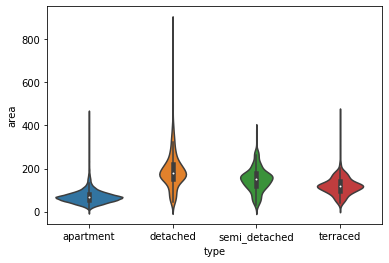

In [7]:
sns.violinplot(x='type', y='area', data=data)
plt.show()

A long tailed distribution is observed for `apartment`, `terraced` and `detached`. Quantile-based discretization should be used in the model.

### Price

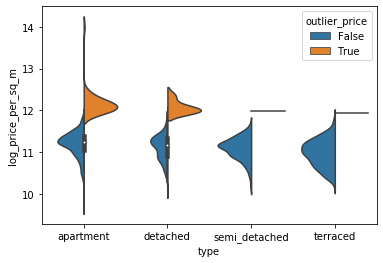

In [8]:
sns.violinplot(x='type', y='log_price_per_sq_m', hue='outlier_price', split=True, data=data)
plt.show()

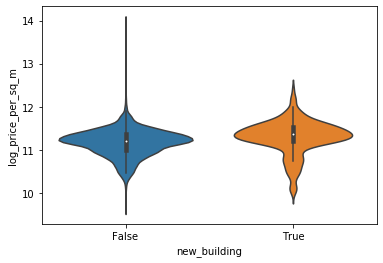

In [9]:
sns.violinplot(x='new_building', y='log_price_per_sq_m', data=data)
plt.show()

In [10]:
n_outliers = len(data[data.outlier_price==True])
n_ads = len(data)

print(f'There are {n_outliers} outliers which constitutes {n_outliers/n_ads:.0%} of the dataset.')

There are 63 outliers which constitutes 1% of the dataset.


### Price As Time Series

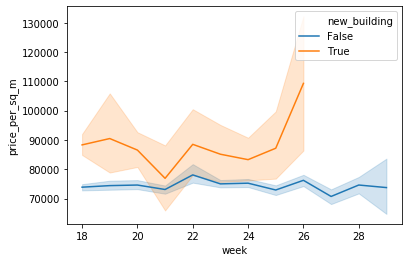

In [11]:
sns.lineplot(x='week', y='price_per_sq_m', hue='new_building', data=data)
plt.show()

The price of existing buildings seems stable over the coourse of the first 3 months, so no need for incorporating inflation rates into the model yet.